In [3]:
# https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

In [16]:
import sys
sys.executable

'/opt/conda/bin/python'

In [18]:
import numpy as np
import pandas as pd


# graphics
import seaborn as sns
import matplotlib.pyplot as plt

# feature and model
import sklearn
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-04.parquet')
# df = df[df.trip_type == 2]
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-04-01 00:18:50,2024-04-01 00:19:48,N,1.0,146,146,1.0,0.15,3.7,1.0,0.5,0.00,0.0,NaN,1.0,6.20,2.0,1.0,0.00
1,2,2024-04-01 00:56:16,2024-04-01 01:12:56,N,1.0,65,225,1.0,3.06,17.7,1.0,0.5,4.04,0.0,NaN,1.0,24.24,1.0,1.0,0.00
2,2,2024-04-01 00:23:09,2024-04-01 00:33:03,N,1.0,226,146,1.0,1.95,11.4,1.0,0.5,3.48,0.0,NaN,1.0,17.38,1.0,1.0,0.00
3,2,2024-03-31 22:34:23,2024-03-31 22:45:33,N,1.0,74,116,1.0,1.93,12.8,1.0,0.5,3.06,0.0,NaN,1.0,18.36,1.0,1.0,0.00
4,2,2024-03-31 23:21:41,2024-03-31 23:29:40,N,1.0,236,238,1.0,1.50,10.7,1.0,0.5,0.80,0.0,NaN,1.0,16.75,1.0,1.0,2.75


In [4]:
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [5]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [6]:
df.duration = df.duration.apply(lambda x: x.total_seconds() / 60) # time in minutes
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-04-01 00:18:50,2024-04-01 00:19:48,N,1.0,146,146,1.0,0.15,3.7,...,0.5,0.00,0.0,NaN,1.0,6.20,2.0,1.0,0.00,0.966667
1,2,2024-04-01 00:56:16,2024-04-01 01:12:56,N,1.0,65,225,1.0,3.06,17.7,...,0.5,4.04,0.0,NaN,1.0,24.24,1.0,1.0,0.00,16.666667
2,2,2024-04-01 00:23:09,2024-04-01 00:33:03,N,1.0,226,146,1.0,1.95,11.4,...,0.5,3.48,0.0,NaN,1.0,17.38,1.0,1.0,0.00,9.900000
3,2,2024-03-31 22:34:23,2024-03-31 22:45:33,N,1.0,74,116,1.0,1.93,12.8,...,0.5,3.06,0.0,NaN,1.0,18.36,1.0,1.0,0.00,11.166667
4,2,2024-03-31 23:21:41,2024-03-31 23:29:40,N,1.0,236,238,1.0,1.50,10.7,...,0.5,0.80,0.0,NaN,1.0,16.75,1.0,1.0,2.75,7.983333


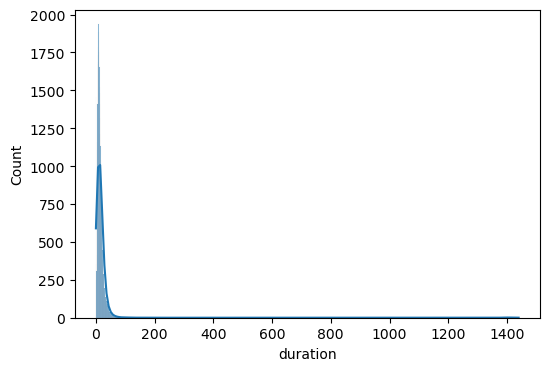

In [7]:
plt.figure(figsize=(6, 4))

sns.histplot(df.duration, kde=True)

plt.show()

In [8]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    56471.000000
mean        18.408817
std         74.060173
min          0.000000
50%         11.650000
95%         35.000000
98%         48.136667
99%         64.633333
max       1439.866667
Name: duration, dtype: float64

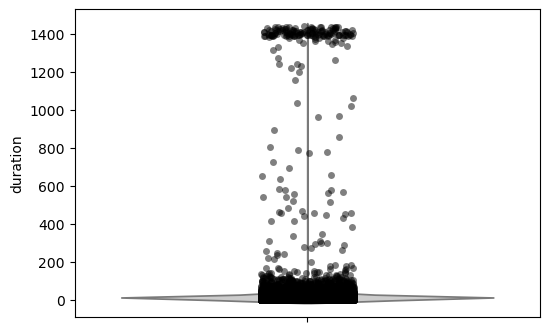

In [9]:
plt.figure(figsize=(6, 4))

# Create the violin plot
sns.violinplot(y='duration', data=df, inner=None, color=".8")
sns.stripplot(y='duration', data=df, jitter=True, color='k', alpha=0.5)

# Show the plot
plt.show()

In [10]:
((df.duration >= 0) & (df.duration <= 100)).mean()

np.float64(0.9946875387366967)

In [11]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'duration'],
      dtype='object')

In [12]:
# categorical = ['PULocationID', 'DOLocationID']
categorical = ['VendorID', 'trip_type']
numerical = ['trip_distance']

### ***Prepare data for modeling***
---

In [27]:
X_train = df[categorical + numerical].dropna()
X_train[categorical] = X_train[categorical].astype(np.int64).astype(str)
X_train.dtypes 

VendorID          object
trip_type         object
trip_distance    float64
dtype: object

In [30]:
X_train[categorical].apply(lambda x: x.unique())

,VendorID,trip_type
0,2,1
1,1,2


In [31]:
# transform numeric features
numeric_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())
           ]
)

# transform categorical features
categorical_transformer = Pipeline(
    steps=[
        # ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
           ("onehot", OneHotEncoder(sparse_output=False, drop= 'first', dtype = np.int64))
           ]
)

# combine both transformations
col_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numerical),
        ("categorical", categorical_transformer, categorical)
    ], 
    remainder='passthrough'    
).set_output(transform='pandas')

In [32]:
col_transformer.fit_transform(X_train)

,numeric__trip_distance,categorical__VendorID_2,categorical__trip_type_2
0,-0.855589,1,0
1,0.165607,1,0
2,-0.223921,1,0
3,-0.230940,1,0
4,-0.381838,1,0
...,...,...,...
54478,0.218246,1,0
54479,-0.157245,1,0
54480,-0.539755,1,0
54481,0.004181,0,0


In [38]:
model = LinearRegression(fit_intercept=True).fit(X_train, y_train)
print(model.intercept_)
print(model.coef_)

16.884607457391937
[-9.24079573e-01  9.24079573e-01  9.30780595e-05  9.15589338e-01
 -2.00445544e+00  1.08886611e+00]


In [39]:
model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
print(model.intercept_)
print(model.coef_)

0.0
[9.20668490e+00 1.10548440e+01 9.30780595e-05 7.66943232e+00
 4.74938754e+00 7.84270909e+00]
